## 1. Imports et Configuration

In [145]:
# Imports standards
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Configuration matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

%matplotlib ipympl

## 2. Ray Tracing by Optical Geometry approximation

This section implements the ray tracing method using concentric annuli, allowing the simulation of light propagation in a medium with a variable refractive index.

In [146]:
def get_n_schwarzschild(R, b_inf, delta_n=0.0):
    if b_inf == 0: 
        return np.inf
    n_ideal = b_inf * np.sqrt((1.0 / b_inf**2) + (2.0 / R**3))
    return n_ideal + delta_n


def trace_ray_visual(b_infinity, num_annuli, R_device=6.0, P_start=15.0, P_end=2.0, full_trajectory=True):
    # VACCUM
    r_points = []
    phi_points = []

    def safe_arcsin(x):
        return np.arcsin(np.clip(x, -1, 1))
    
    # Starting point
    phi_start = safe_arcsin(b_infinity / P_start)
    r_points.append(P_start)
    phi_points.append(phi_start)
    
    # Entry into black hole device
    if P_start > R_device:
        phi_entry = safe_arcsin(b_infinity / R_device)
        r_points.append(R_device)
        phi_points.append(phi_entry)
        current_phi = phi_entry
    else:
        current_phi = phi_start

    # Discrete annuli
    radii = np.linspace(R_device, P_end, num_annuli + 1)
    mid_radii = (radii[:-1] + radii[1:]) / 2.0
    n_values = get_n_schwarzschild(mid_radii, b_infinity, delta_n=0.0)
    
    invariant_C = b_infinity 
    hit_horizon = True 
    
    # Ray tracing through annuli                            
    for i in range(num_annuli):
        n_i = n_values[i]
        R_outer = radii[i]
        R_inner = radii[i+1]
        B_i = invariant_C / n_i
        
        if B_i >= R_inner:
            hit_horizon = False 
            if B_i < R_outer:
                phi_in = safe_arcsin(B_i / R_outer)
                phi_peri = np.pi / 2
                d_phi = phi_peri - phi_in
                
                current_phi += d_phi
                r_points.append(B_i)
                phi_points.append(current_phi)
            break 
        else:
            term1 = safe_arcsin(B_i / R_inner)
            term2 = safe_arcsin(B_i / R_outer)
            d_phi = term1 - term2
            
            current_phi += d_phi
            r_points.append(R_inner)
            phi_points.append(current_phi)

    # Full trajectory by symmetry
    if full_trajectory and not hit_horizon:
        phi_periastre = phi_points[-1]
        r_out = r_points[-2::-1] 
        phi_in_reversed = phi_points[-2::-1]
        phi_out = [2 * phi_periastre - p for p in phi_in_reversed]
        
        r_points.extend(r_out)
        phi_points.extend(phi_out)
            
    # Convert to Cartesian for plotting
    r_arr = np.array(r_points)
    phi_arr = np.array(phi_points)
    
    X = r_arr * np.cos(phi_arr)
    Y = r_arr * np.sin(phi_arr)
    
    return X, Y, radii, phi_arr, r_arr

### Visualization : Trajectory of a light ray

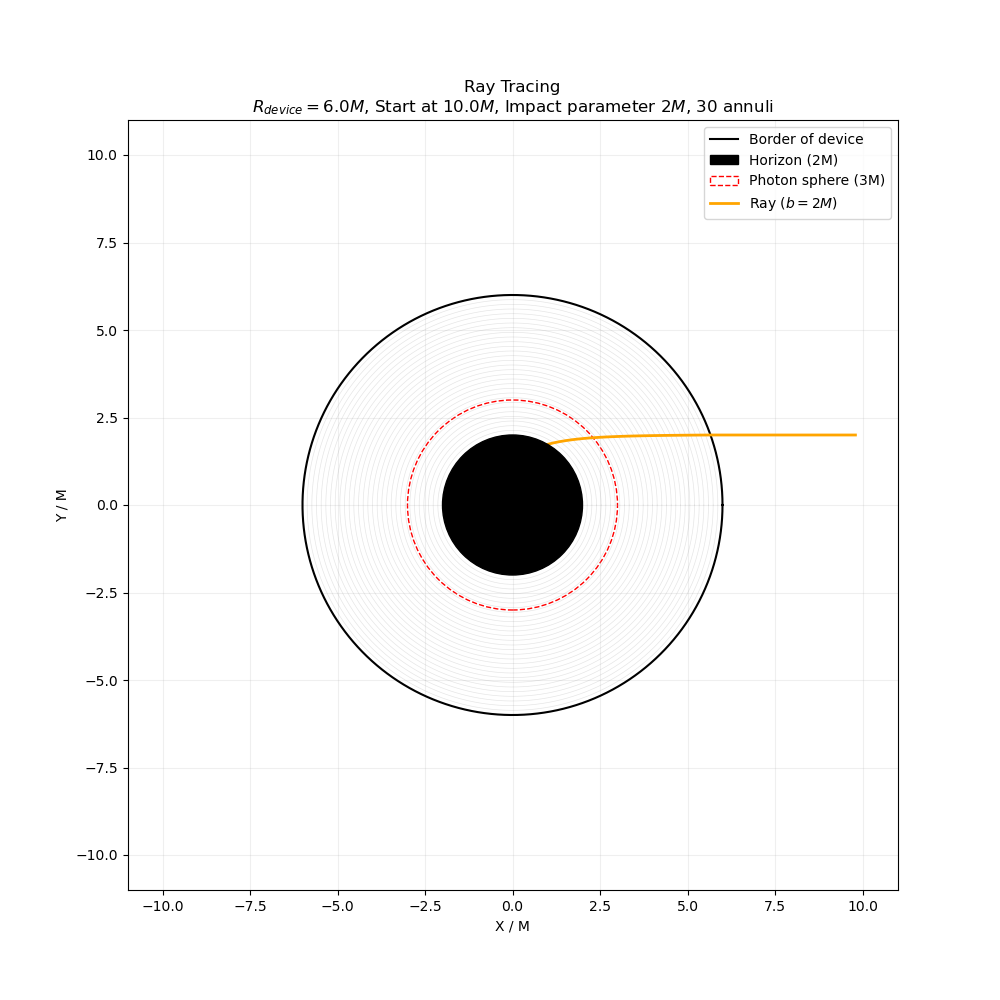

In [155]:
# Simulation parameters
b_inf = 2
R_device = 6.0
P_start = 10.0
N_annuli = 30
N_annuli_display = 1

# Ray tracing calculation
x_ray, y_ray, annuli, _, _ = trace_ray_visual(
    b_inf, N_annuli, R_device, P_start, P_end=2.0, full_trajectory=True
)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Device annuli
theta = np.linspace(0, 2*np.pi, 200)
ax.plot(R_device * np.cos(theta), R_device * np.sin(theta), 
        'k-', linewidth=1.5, label='Border of device')
for r in annuli[1::N_annuli_display]:  # Display 1 annulus out of 100
    ax.plot(r * np.cos(theta), r * np.sin(theta), 
            color='gray', alpha=0.2, linewidth=0.5)

# Black hole and photon sphere
circle_bh = plt.Circle((0, 0), 2.0, color='black', zorder=10, label='Horizon (2M)')
circle_ps = plt.Circle((0, 0), 3.0, color='red', fill=False, 
                       linestyle='--', label='Photon sphere (3M)')
ax.add_patch(circle_bh)
ax.add_patch(circle_ps)

# Ray trajectory
ax.plot(x_ray, y_ray, color='orange', linewidth=2, 
        label=f'Ray ($b={b_inf}M$)')

# Axis configuration
limit = P_start + 1
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_aspect('equal')
ax.set_xlabel('X / M')
ax.set_ylabel('Y / M')
ax.legend(loc='upper right')
ax.set_title(f'Ray Tracing\n' +
             f'$R_{{device}}={R_device}M$, Start at ${P_start}M$, Impact parameter ${b_inf}M$, {N_annuli} annuli')
ax.grid(True, alpha=0.2)
plt.show()


## 3. Null geodesics integration

Computation of the null geodesics from GR equations.

In [148]:
def geodesic_integrand(rho, b_infinity):
    denom_sq = (rho**4 / b_infinity**2) - rho**2 + 2*rho
    
    if denom_sq <= 0:
        return 0
    
    return 1.0 / np.sqrt(denom_sq)


def calculate_exact_geodesic(b_infinity, P_start, P_end_list):
    phi_values = []
    phi_0 = np.arcsin(b_infinity / P_start)
    
    for P in P_end_list:
        delta_phi, error = quad(geodesic_integrand, P, P_start, args=(b_infinity,))
        phi_values.append(phi_0 + delta_phi)
        
    return np.array(phi_values)


def get_ray_phi_at_radius(b_infinity, num_annuli, target_radius, 
                          R_device=6.0, P_start=15.0, P_end=2.0):
    _, _, _, phi_ray, r_ray = trace_ray_visual(
        b_infinity, num_annuli, R_device=R_device, 
        P_start=P_start, P_end=P_end, full_trajectory=False
    )
    
    # Vérifier si le rayon atteint target_radius
    r_min = np.min(r_ray)
    
    if r_min > target_radius:
        # Le rayon n'atteint pas target_radius (périastre trop élevé)
        return None
    
    # Interpolation linéaire pour trouver phi à target_radius
    if target_radius in r_ray:
        idx = np.where(r_ray == target_radius)[0][0]
        return phi_ray[idx]
    else:
        # Trouver les deux points encadrants
        # Les r_ray sont dans l'ordre décroissant généralement
        r_sorted_idx = np.argsort(r_ray)
        r_sorted = r_ray[r_sorted_idx]
        phi_sorted = phi_ray[r_sorted_idx]
        
        # Interpolation
        phi_interp = np.interp(target_radius, r_sorted, phi_sorted)
        return phi_interp

### Comparaison : Ray Tracing vs Null Geodesics

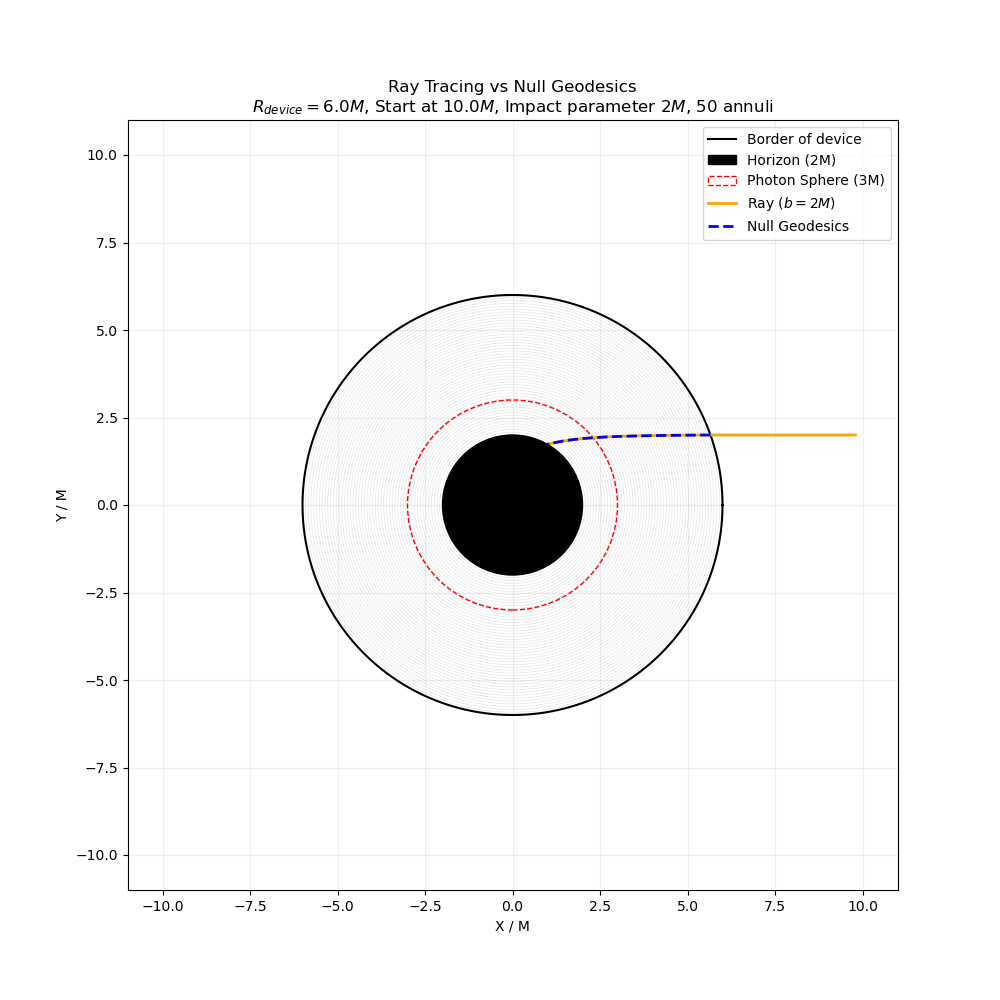

Ray Tracing and Null Geodesics plotted successfully.
60.009481367642906
60.02000551073482
Absolute Error: 0.01052414309191363
Relative Error (%): 0.01753746716696046


In [159]:
# Simulation parameters
b_inf = 2
R_device = 6.0
P_start = 10.0
N_annuli = 50
N_annuli_display = 1

# Ray tracing calculation
x_ray, y_ray, annuli, phi_ray, _ = trace_ray_visual(
    b_inf, N_annuli, R_device=R_device, P_start=P_start, 
    P_end=2.0, full_trajectory=True
)

# Null geodesic calculation
r_exact = np.linspace(R_device, 2, 200)
phi_exact = calculate_exact_geodesic(b_inf, R_device, r_exact)
x_exact = r_exact * np.cos(phi_exact)
y_exact = r_exact * np.sin(phi_exact)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Device annuli
theta = np.linspace(0, 2*np.pi, 200)
ax.plot(R_device * np.cos(theta), R_device * np.sin(theta), 
        'k-', linewidth=1.5, label='Border of device')
for r in annuli[1::N_annuli_display]:  # Display 1 annulus out of 100
    ax.plot(r * np.cos(theta), r * np.sin(theta), 
            color='gray', alpha=0.2, linewidth=0.5)

# Black hole and photon sphere
circle_bh = plt.Circle((0, 0), 2.0, color='black', zorder=10, label='Horizon (2M)')
circle_ps = plt.Circle((0, 0), 3.0, color='red', fill=False, 
                       linestyle='--', label='Photon Sphere (3M)')
ax.add_patch(circle_bh)
ax.add_patch(circle_ps)

# Ray trajectory & Null geodesics
ax.plot(x_ray, y_ray, color='orange', linewidth=2, 
        label=f'Ray ($b={b_inf}M$)')
ax.plot(x_exact, y_exact, color='blue', linestyle='--', linewidth=2,
        label='Null Geodesics')

# Axis configuration
limit = P_start + 1
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_aspect('equal')
ax.set_xlabel('X / M')
ax.set_ylabel('Y / M')
ax.legend(loc='upper right')
ax.set_title(f'Ray Tracing vs Null Geodesics\n' +
             f'$R_{{device}}={R_device}M$, Start at ${P_start}M$, Impact parameter ${b_inf}M$, {N_annuli} annuli')
ax.grid(True, alpha=0.2)
plt.show()

print("Ray Tracing and Null Geodesics plotted successfully.")
print(np.degrees(phi_exact[-1]))
print(np.degrees(phi_ray[-1]))
print("Absolute Error:", np.abs(np.degrees(phi_exact[-1]) - np.degrees(phi_ray[-1])))
print("Relative Error (%):", 
      np.abs(np.degrees(phi_exact[-1]) - np.degrees(phi_ray[-1])) / np.abs(np.degrees(phi_exact[-1])) * 100)

## 4. Error Analysis: Ray Tracing vs Geodesics

Completed calculation for b_inf = 2.0M
Completed calculation for b_inf = 2.5M
Completed calculation for b_inf = 3.0M
Completed calculation for b_inf = 3.5M
Completed calculation for b_inf = 4.0M
Completed calculation for b_inf = 4.5M
Completed calculation for b_inf = 5.0M


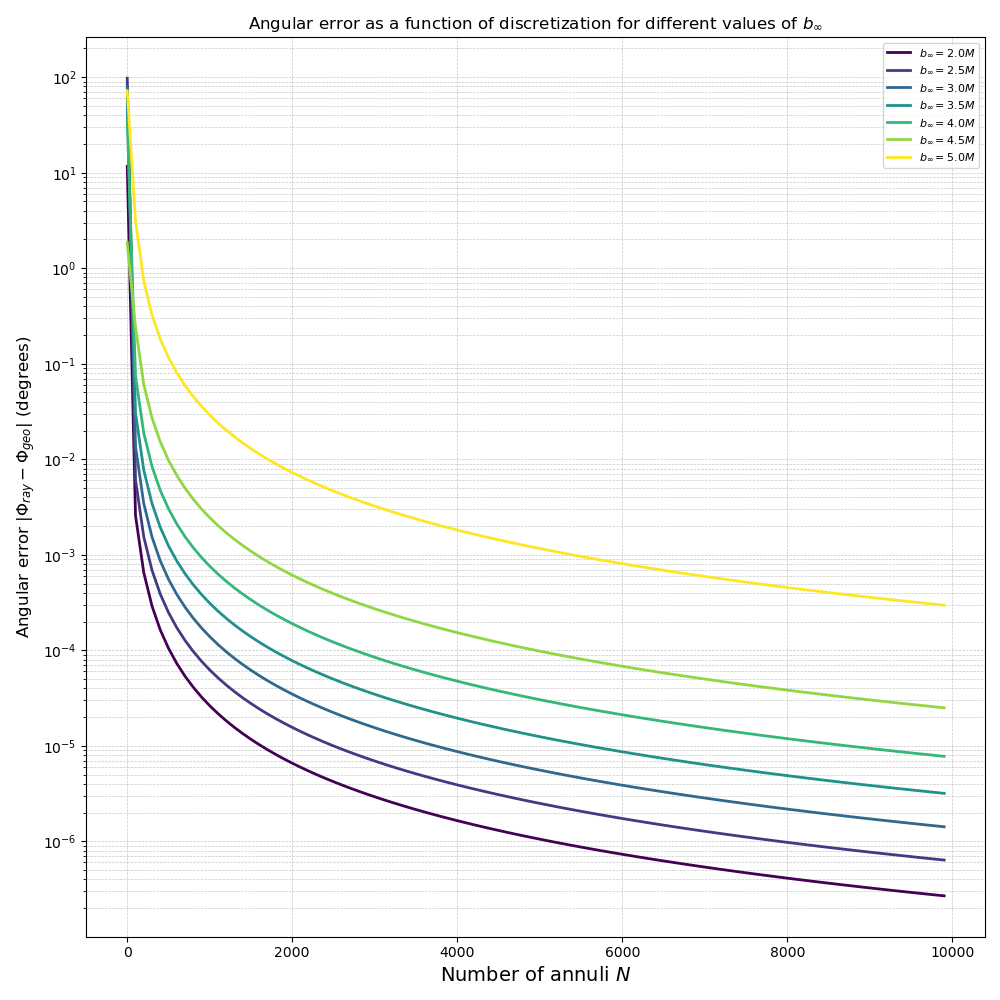

In [150]:
# Select multiple values of b_inf
b_values = np.linspace(2.0, 5.0, 7)  # 7 values of b between 2 and 5
R_device = 6.0
P_start = 15.0
P_end_target = 2.0
N_anneaux = np.arange(1, 10000, 100)

# Exact calculation (geodesic)
r_exact = np.linspace(R_device, 2, 200)

# Plot error as a function of N for different values of b
plt.figure(figsize=(10, 10))

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(b_values)))

for idx, b_inf in enumerate(b_values):
    error = []
    
    for N in N_anneaux:
        # Ray tracing calculation (approximation)
        x_ray, y_ray, annuli, phi_ray, _ = trace_ray_visual(
            b_inf, N, R_device=R_device, P_start=P_start, 
            P_end=2.0, full_trajectory=True
        )
        
        # Calculate error on phi at P_end_target
        phi_exact = calculate_exact_geodesic(b_inf, R_device, r_exact)
        phi_exact_end = phi_exact[-1]
        phi_ray_end = phi_ray[-1]
        
        error_phi = (phi_ray_end - phi_exact_end)
        error_phi_deg = np.degrees(error_phi)
        error.append(np.abs(error_phi_deg))
    
    # Plot curve for this b_inf
    plt.plot(N_anneaux, error, color=colors[idx], lw=2, 
             label=rf'$b_{{\infty}} = {b_inf:.1f}M$')
    
    print(f"Completed calculation for b_inf = {b_inf:.1f}M")

plt.xlabel('Number of annuli $N$', fontsize=14)
plt.ylabel(r'Angular error $|\Phi_{ray} - \Phi_{geo}|$ (degrees)', fontsize=12)
plt.title(r'Angular error as a function of discretization for different values of $b_{\infty}$', 
          fontsize=12)
plt.legend(loc='best', fontsize=8)
plt.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
plt.yscale('log')  
plt.tight_layout()
plt.show()

## 4. Experimental errors analysis

This section reproduces Figures 6a and 6c from the paper, showing the effect of refractive index and laser positioning errors.

In [151]:
def trace_single_ray_corrected(b_ray, b_struc,num_annuli, R_device=6.0, P_start=15.0, P_end=2.0, delta_n=0.0):
    
    r_points = []
    phi_points = []
    
    def safe_arcsin(x):
        return np.arcsin(np.clip(x, -1, 1))
    
    # Indice au départ (incluant l'erreur)
    n_start = 1.0 + delta_n
    invariant_C = b_ray * n_start
    
    # Initialisation
    P_start = 10.0 
    phi_start = safe_arcsin(b_ray / P_start)
    
    r_points.append(P_start)
    phi_points.append(phi_start)
    
    if P_start > R_device:
        phi_entry = safe_arcsin(b_ray / R_device)
        r_points.append(R_device)
        phi_points.append(phi_entry)
        current_phi = phi_entry
    else:
        current_phi = phi_start

    # Discrete annuli
    radii = np.linspace(R_device, P_end, num_annuli + 1)
    mid_radii = (radii[:-1] + radii[1:]) / 2.0
    n_values = get_n_schwarzschild(mid_radii, b_struc, delta_n)
    
    # Traversée
    for i in range(num_annuli):
        n_i = n_values[i]
        R_outer = radii[i]
        R_inner = radii[i+1]
        B_i = invariant_C / n_i
        
        if B_i >= R_inner:
            if B_i < R_outer:
                phi_in = safe_arcsin(B_i / R_outer)
                phi_peri = np.pi / 2
                d_phi = phi_peri - phi_in
                current_phi += d_phi
                r_points.append(B_i)
                phi_points.append(current_phi)
            break
        else:
            term1 = safe_arcsin(B_i / R_inner)
            term2 = safe_arcsin(B_i / R_outer)
            d_phi = term1 - term2
            current_phi += d_phi
            r_points.append(R_inner)
            phi_points.append(current_phi)
            
    r_arr = np.array(r_points)
    phi_arr = np.array(phi_points)
    X = r_arr * np.cos(phi_arr)
    Y = r_arr * np.sin(phi_arr)
    return X, Y

In [152]:
num_annuli = 50

def plot_error_analysis(mode='delta_n'):
    R_device = 6.0
    b_ref = 3.0
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Decoration: annuli and horizon
    theta = np.linspace(0, np.pi, 300)
    for r in np.linspace(2.0, 6.0, 12):
        ax.plot(r * np.cos(theta), r * np.sin(theta), 
                color='gray', lw=0.5, alpha=0.4)
    ax.plot(R_device * np.cos(theta), R_device * np.sin(theta), 
            color='gray', lw=1.0)
    
    horizon = plt.Circle((0, 0), 2.0, color='white', zorder=10)
    ax.add_patch(horizon)
    ax.plot(2.0 * np.cos(theta), 2.0 * np.sin(theta), 
            color='black', lw=1.0)

    # Configuration according to mode
    num_lines = 100
    cmap = plt.get_cmap('gnuplot2') 
    
    if mode == 'delta_n':
        title = r"Effect of refractive index error $\Delta n$"
        label_bar = r"$\Delta n$"
        
        values = np.linspace(0.0, 0.5, num_lines)
        norm = mcolors.Normalize(vmin=0, vmax=0.5)
        
        # Reference Ray
        xref, yref = trace_single_ray_corrected(
            b_ray=b_ref, b_struc=b_ref, num_annuli=num_annuli, R_device=6.0, P_start=15.0, P_end=2.0, delta_n=0.0
        )
        ax.plot(xref, yref, color='black', linestyle='--', 
                lw=2, zorder=20, label='Reference ray')

        # Trajectories with error
        for val in values:
            x, y = trace_single_ray_corrected(
                b_ray=b_ref, b_struc=b_ref, num_annuli=num_annuli, R_device=6.0, P_start=15.0, P_end=2.0, delta_n=val
            )
            if x is not None:
                color = cmap(norm(val))
                ax.plot(x, y, color=color, lw=2, alpha=0.6, zorder=10)

    elif mode == 'delta_b':
        # Figure 6c: Positioning error
        title = r"Effect of positioning error $\Delta B_0$"
        label_bar = r"$\Delta B_0 / B_0$ (%)"
        
        percentages = np.linspace(-0.10, 0.10, num_lines)
        norm = mcolors.Normalize(vmin=-10, vmax=10)
        
        # Reference
        xref, yref = trace_single_ray_corrected(
            b_ray=b_ref, b_struc=b_ref, num_annuli=num_annuli, R_device=6.0, P_start=15.0, P_end=2.0, delta_n=0.0
        )
        ax.plot(xref, yref, color='black', linestyle='--', 
                lw=2, zorder=20, label='Reference ray')

        # Trajectories with positioning error
        for pct in percentages:
            b_current = b_ref * (1.0 + pct)
            x, y = trace_single_ray_corrected(
                b_ray=b_current, b_struc=b_ref, num_annuli=num_annuli, R_device=6.0, P_start=15.0, P_end=2.0, delta_n=0.0
            )
            if x is not None:
                color = cmap(mcolors.Normalize(vmin=-0.1, vmax=0.1)(pct))
                ax.plot(x, y, color=color, lw=2, alpha=0.6, zorder=10)

    # Axis configuration
    ax.set_aspect('equal')
    ax.set_xlim(-2, 6.5)
    ax.set_ylim(0, 6.5)
    ax.set_xlabel('$X / M$')
    ax.set_ylabel('$Y / M$')
    
    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(label_bar)
    
    ax.legend(loc='upper left')
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Effect of refractive index error $\Delta n$

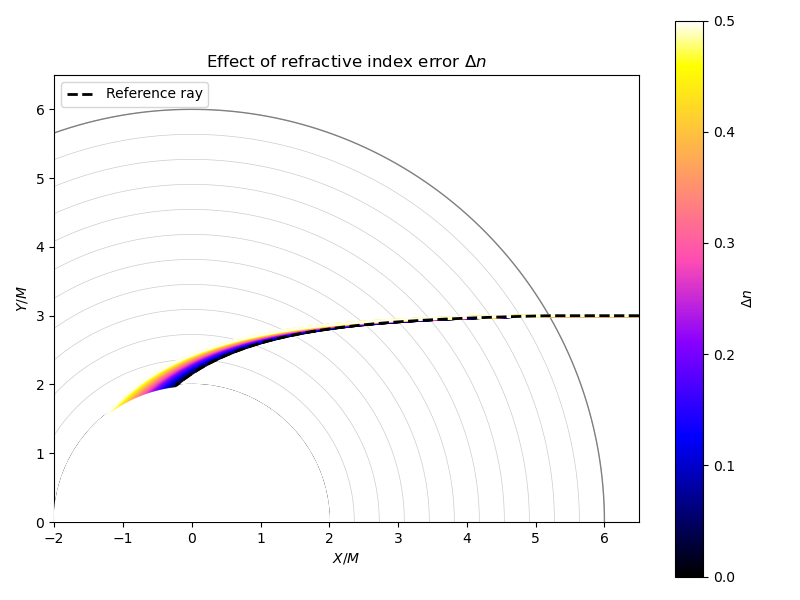

In [153]:
plot_error_analysis(mode='delta_n')

### Effect of positioning error $\Delta B_0$

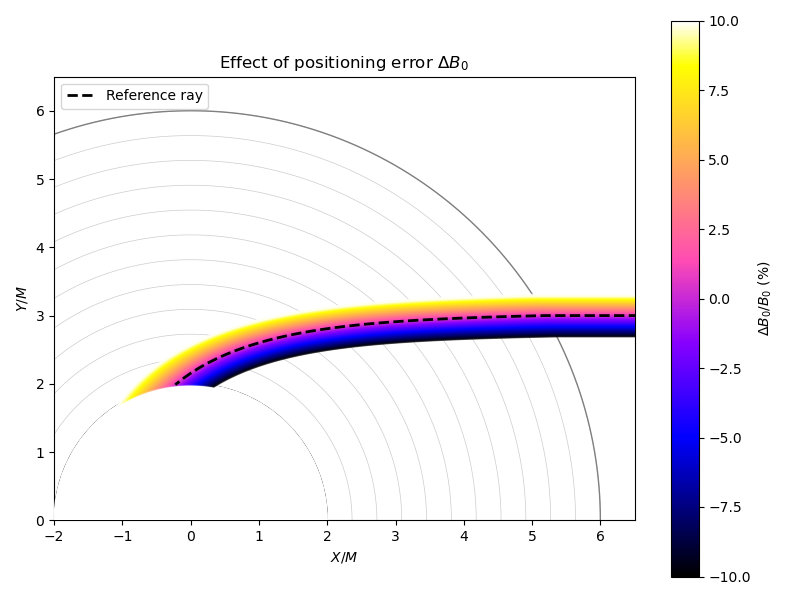

In [154]:
plot_error_analysis(mode='delta_b')